<a href="https://colab.research.google.com/github/karthikmswamy/TF_Intro_Notebooks/blob/master/TF_DF_with_Data_Variations_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installs

In [ ]:
# !pip install -U augly
# !sudo apt-get install python3-magic
!pip install tensorflow_decision_forests
!pip install wurlitzer

## Imports

In [ ]:
from time import time

import tensorflow_decision_forests as tfdf
import pandas as pd
import tensorflow as tf
try:
  from wurlitzer import sys_pipes
except:
  from colabtools.googlelog import CaptureLog as sys_pipes

from IPython.core.magic import register_line_magic
from IPython.display import Javascript
import matplotlib.pyplot as plt

## Data Download and Check

In [ ]:
! wget -O bestBuy.csv "https://raw.githubusercontent.com/SAP-samples/data-attribute-recommendation-postman-tutorial-sample/master/Tutorial_Example_Dataset.csv"

# Load a dataset into a Pandas Dataframe.
dataset_df = pd.read_csv("./bestBuy.csv", usecols=['manufacturer', 'price', 'description'])

# Display the first 3 examples.
dataset_df.head(3)

--2021-08-04 11:33:17--  https://raw.githubusercontent.com/SAP-samples/data-attribute-recommendation-postman-tutorial-sample/master/Tutorial_Example_Dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9921374 (9.5M) [text/plain]
Saving to: ‘bestBuy.csv’

bestBuy.csv         100%[===================>]   9.46M  --.-KB/s    in 0.1s    

2021-08-04 11:33:17 (78.4 MB/s) - ‘bestBuy.csv’ saved [9921374/9921374]



,description,manufacturer,price
0,Compatible with select electronic devices; AAA...,Duracell,5.49
1,Long-lasting energy; DURALOCK Power Preserve t...,Duracell,5.49
2,Compatible with select electronic devices; AA ...,Duracell,7.49


In [ ]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48087 entries, 0 to 48086
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   description   48087 non-null  object 
 1   manufacturer  48023 non-null  object 
 2   price         48087 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [ ]:
# Name of the label column.
label = "price"

# classes = dataset_df[label].unique().tolist()
# print(f"Label classes: {classes}")

# dataset_df[label] = dataset_df[label].map(classes.index)

## Helper Methods

In [ ]:
# Split the dataset into a training and a testing dataset.
# Test split remains a constant 
def split_dataset(dataset, num_train=10000):
  """Splits a panda dataframe in two."""
  dataset = dataset.sample(frac=1.0, random_state=1729)
  
  test_dataset = dataset[40000:]
  train_dataset = dataset[:num_train]
  
  return train_dataset, test_dataset

In [ ]:
def train_rf_model_with_dataframes(train_df, test_df, label):
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, 
                                                     label=label, 
                                                     task=tfdf.keras.Task.REGRESSION)
    test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, 
                                                    label=label, 
                                                    task=tfdf.keras.Task.REGRESSION)

    # Specify the model.
    model_1 = tfdf.keras.RandomForestModel(num_trees=30, task=tfdf.keras.Task.REGRESSION)

    # Optionally, add evaluation metrics.
    model_1.compile(metrics=["mse"])

    t1 = time()
    # Train the model.
    with sys_pipes():
        model_1.fit(x=train_ds)

    evaluation = model_1.evaluate(test_ds, return_dict=True)

    print(f"MSE: {evaluation['mse']} in {time() - t1} secs")
    return evaluation['mse'], time() - t1

In [ ]:
def train_gbdt_model_with_dataframes(train_df, test_df, label):
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, 
                                                     label=label, 
                                                     task=tfdf.keras.Task.REGRESSION)
    test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, 
                                                    label=label, 
                                                    task=tfdf.keras.Task.REGRESSION)

    # Specify the model.
    model_1 = tfdf.keras.GradientBoostedTreesModel(num_trees=30,
                                                   task=tfdf.keras.Task.REGRESSION)

    # Optionally, add evaluation metrics.
    model_1.compile(metrics=["mse"])

    t1 = time()
    # Train the model.
    with sys_pipes():
        model_1.fit(x=train_ds)

    evaluation = model_1.evaluate(test_ds, return_dict=True)

    print(f"MSE: {evaluation['mse']} in {time() - t1} secs")
    return evaluation['mse'], time() - t1

In [ ]:
def train_cart_model_with_dataframes(train_df, test_df, label):
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, 
                                                     label=label, 
                                                     task=tfdf.keras.Task.REGRESSION)
    test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, 
                                                    label=label, 
                                                    task=tfdf.keras.Task.REGRESSION)

    # Specify the model.
    model_1 = tfdf.keras.CartModel(task=tfdf.keras.Task.REGRESSION)

    # Optionally, add evaluation metrics.
    model_1.compile(metrics=["mse"])

    t1 = time()
    # Train the model.
    with sys_pipes():
        model_1.fit(x=train_ds)

    evaluation = model_1.evaluate(test_ds, return_dict=True)

    print(f"MSE: {evaluation['mse']} in {time() - t1} secs")
    return evaluation['mse'], time() - t1

## Train with Different Records

In [ ]:
def train_and_evaluate_on_data(num_train, results_rf, results_gb, results_cm):
    train_ds_pd, test_ds_pd = split_dataset(dataset_df, num_train)
    print(f"{len(train_ds_pd)} examples in training, {len(test_ds_pd)} examples for testing.")

    accuracy, time_taken = train_rf_model_with_dataframes(train_ds_pd, test_ds_pd, label)
    results_rf.append([num_train, accuracy, time_taken])

    accuracy, time_taken = train_gbdt_model_with_dataframes(train_ds_pd, test_ds_pd, label)
    results_gb.append([num_train, accuracy, time_taken])

    accuracy, time_taken = train_cart_model_with_dataframes(train_ds_pd, test_ds_pd, label)
    results_cm.append([num_train, accuracy, time_taken])

    return results_rf, results_gb, results_cm

In [ ]:
results_rf, results_gb, results_cm = [], [], []
num_train_list = [500, 1000, 2000, 4000, 8000, 16000, 32000, 40000]
for num_train in num_train_list:
    results_rf, results_gb, results_cm = train_and_evaluate_on_data(num_train, results_rf, results_gb, results_cm)

500 examples in training, 8087 examples for testing.


2021-08-04 11:33:22.652240: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-04 11:33:22.654482: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2199995000 Hz


8/8 [==============================] - 4s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 8
[INFO kernel.cc:393] Number of examples: 500
[INFO data_spec_inference.cc:289] 492 item(s) have been pruned (i.e. they are considered out of dictionary) for the column description (0 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:289] 287 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (15 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 500
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "description" CATEGORICAL has-dict vocab-size:1 num-oods:492 (98.4%)
	1: "manufacturer" CATEGORICAL num-nas:1 (0.2%) has-dict vocab-size:16 num-oods:287 (57.515%) most-frequent:"<OOD>" 28

127/127 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 269679.3438
MSE: 269679.34375 in 7.440796613693237 secs
8/8 [==============================] - 0s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 8
[INFO kernel.cc:393] Number of examples: 500
[INFO data_spec_inference.cc:289] 492 item(s) have been pruned (i.e. they are considered out of dictionary) for the column description (0 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:289] 287 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (15 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 500
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "description" CATEGORICAL has-dict vocab-size:1 num-oods:492 (98.4%)
	1: "manufacturer" CATEGORICAL num-nas:1 (0.2%) has-dict vocab-size:16 num-oods:287 (57.515%) most-frequent:"<OOD>" 28

127/127 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 272940.0938
MSE: 272940.09375 in 0.6914722919464111 secs
8/8 [==============================] - 0s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 8
[INFO kernel.cc:393] Number of examples: 500
[INFO data_spec_inference.cc:289] 492 item(s) have been pruned (i.e. they are considered out of dictionary) for the column description (0 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:289] 287 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (15 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 500
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "description" CATEGORICAL has-dict vocab-size:1 num-oods:492 (98.4%)
	1: "manufacturer" CATEGORICAL num-nas:1 (0.2%) has-dict vocab-size:16 num-oods:287 (57.515%) most-frequent:"<OOD>" 28

127/127 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 293103.0938
MSE: 293103.09375 in 0.4357109069824219 secs
1000 examples in training, 8087 examples for testing.
16/16 [==============================] - 0s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 16
[INFO kernel.cc:393] Number of examples: 1000
[INFO data_spec_inference.cc:289] 981 item(s) have been pruned (i.e. they are considered out of dictionary) for the column description (1 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:289] 449 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (36 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 1000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "description" CATEGORICAL has-dict vocab-size:2 num-oods:981 (98.1%) most-frequent:"<OOD>" 981 (98.1%)
	1: "manufacturer" CATEGORICAL num-nas:1 (0.1%) has-dict vocab-size:37 num-oods:4

127/127 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 246594.3750
MSE: 246594.375 in 0.6491308212280273 secs
16/16 [==============================] - 0s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 16
[INFO kernel.cc:393] Number of examples: 1000
[INFO data_spec_inference.cc:289] 981 item(s) have been pruned (i.e. they are considered out of dictionary) for the column description (1 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:289] 449 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (36 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 1000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "description" CATEGORICAL has-dict vocab-size:2 num-oods:981 (98.1%) most-frequent:"<OOD>" 981 (98.1%)
	1: "manufacturer" CATEGORICAL num-nas:1 (0.1%) has-dict vocab-size:37 num-oods:4

127/127 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 262392.1875
MSE: 262392.1875 in 0.6935760974884033 secs
16/16 [==============================] - 0s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 16
[INFO kernel.cc:393] Number of examples: 1000
[INFO data_spec_inference.cc:289] 981 item(s) have been pruned (i.e. they are considered out of dictionary) for the column description (1 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:289] 449 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (36 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 1000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "description" CATEGORICAL has-dict vocab-size:2 num-oods:981 (98.1%) most-frequent:"<OOD>" 981 (98.1%)
	1: "manufacturer" CATEGORICAL num-nas:1 (0.1%) has-dict vocab-size:37 num-oods:4

127/127 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 293418.6875
MSE: 293418.6875 in 0.7029500007629395 secs
2000 examples in training, 8087 examples for testing.
32/32 [==============================] - 0s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 32
[INFO kernel.cc:393] Number of examples: 2000
[INFO data_spec_inference.cc:289] 1939 item(s) have been pruned (i.e. they are considered out of dictionary) for the column description (1 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:289] 614 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (88 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 2000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "description" CATEGORICAL has-dict vocab-size:2 num-oods:1939 (96.95%) most-frequent:"<OOD>" 1939 (96.95%)
	1: "manufacturer" CATEGORICAL num-nas:3 (0.15%) has-dict vocab-size:89 num-

127/127 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 216878.3750
MSE: 216878.375 in 0.8594691753387451 secs
32/32 [==============================] - 0s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 32
[INFO kernel.cc:393] Number of examples: 2000
[INFO data_spec_inference.cc:289] 1939 item(s) have been pruned (i.e. they are considered out of dictionary) for the column description (1 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:289] 614 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (88 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 2000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "description" CATEGORICAL has-dict vocab-size:2 num-oods:1939 (96.95%) most-frequent:"<OOD>" 1939 (96.95%)
	1: "manufacturer" CATEGORICAL num-nas:3 (0.15%) has-dict vocab-size:89 num-

127/127 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 221099.3438
MSE: 221099.34375 in 0.6145169734954834 secs
32/32 [==============================] - 0s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 32
[INFO kernel.cc:393] Number of examples: 2000
[INFO data_spec_inference.cc:289] 1939 item(s) have been pruned (i.e. they are considered out of dictionary) for the column description (1 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:289] 614 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (88 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 2000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "description" CATEGORICAL has-dict vocab-size:2 num-oods:1939 (96.95%) most-frequent:"<OOD>" 1939 (96.95%)
	1: "manufacturer" CATEGORICAL num-nas:3 (0.15%) has-dict vocab-size:89 num-

127/127 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 292985.5625
MSE: 292985.5625 in 0.5443425178527832 secs
4000 examples in training, 8087 examples for testing.
63/63 [==============================] - 0s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 63
[INFO kernel.cc:393] Number of examples: 4000
[INFO data_spec_inference.cc:289] 3794 item(s) have been pruned (i.e. they are considered out of dictionary) for the column description (2 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:289] 759 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (212 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 4000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "description" CATEGORICAL has-dict vocab-size:3 num-oods:3794 (94.85%) most-frequent:"<OOD>" 3794 (94.85%)
	1: "manufacturer" CATEGORICAL num-nas:5 (0.125%) has-dict vocab-size:213 n

127/127 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 210317.1719
MSE: 210317.171875 in 1.1597154140472412 secs
63/63 [==============================] - 0s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 63
[INFO kernel.cc:393] Number of examples: 4000
[INFO data_spec_inference.cc:289] 3794 item(s) have been pruned (i.e. they are considered out of dictionary) for the column description (2 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:289] 759 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (212 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 4000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "description" CATEGORICAL has-dict vocab-size:3 num-oods:3794 (94.85%) most-frequent:"<OOD>" 3794 (94.85%)
	1: "manufacturer" CATEGORICAL num-nas:5 (0.125%) has-dict vocab-size:213 n

127/127 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 210001.8438
MSE: 210001.84375 in 0.8527331352233887 secs
63/63 [==============================] - 0s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 63
[INFO kernel.cc:393] Number of examples: 4000
[INFO data_spec_inference.cc:289] 3794 item(s) have been pruned (i.e. they are considered out of dictionary) for the column description (2 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:289] 759 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (212 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 4000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "description" CATEGORICAL has-dict vocab-size:3 num-oods:3794 (94.85%) most-frequent:"<OOD>" 3794 (94.85%)
	1: "manufacturer" CATEGORICAL num-nas:5 (0.125%) has-dict vocab-size:213 n

127/127 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 214235.8281
MSE: 214235.828125 in 0.5350396633148193 secs
8000 examples in training, 8087 examples for testing.
125/125 [==============================] - 0s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 125
[INFO kernel.cc:393] Number of examples: 8000
[INFO data_spec_inference.cc:289] 7299 item(s) have been pruned (i.e. they are considered out of dictionary) for the column description (11 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:289] 906 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (381 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 8000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "description" CATEGORICAL has-dict vocab-size:12 num-oods:7299 (91.2375%) most-frequent:"<OOD>" 7299 (91.2375%)
	1: "manufacturer" CATEGORICAL num-nas:8 (0.1%) has-dict vocab-size:

127/127 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mse: 194922.5469
MSE: 194922.546875 in 5.648832082748413 secs
125/125 [==============================] - 0s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 125
[INFO kernel.cc:393] Number of examples: 8000
[INFO data_spec_inference.cc:289] 7299 item(s) have been pruned (i.e. they are considered out of dictionary) for the column description (11 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:289] 906 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (381 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 8000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "description" CATEGORICAL has-dict vocab-size:12 num-oods:7299 (91.2375%) most-frequent:"<OOD>" 7299 (91.2375%)
	1: "manufacturer" CATEGORICAL num-nas:8 (0.1%) has-dict vocab-size:

127/127 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 197832.9531
MSE: 197832.953125 in 5.670016288757324 secs
125/125 [==============================] - 0s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 125
[INFO kernel.cc:393] Number of examples: 8000
[INFO data_spec_inference.cc:289] 7299 item(s) have been pruned (i.e. they are considered out of dictionary) for the column description (11 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:289] 906 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (381 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 8000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "description" CATEGORICAL has-dict vocab-size:12 num-oods:7299 (91.2375%) most-frequent:"<OOD>" 7299 (91.2375%)
	1: "manufacturer" CATEGORICAL num-nas:8 (0.1%) has-dict vocab-size:

127/127 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 278359.1875
MSE: 278359.1875 in 1.0239930152893066 secs
16000 examples in training, 8087 examples for testing.
250/250 [==============================] - 0s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 250
[INFO kernel.cc:393] Number of examples: 16000
[INFO data_spec_inference.cc:289] 13722 item(s) have been pruned (i.e. they are considered out of dictionary) for the column description (61 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:289] 1024 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (626 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 16000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "description" CATEGORICAL has-dict vocab-size:62 num-oods:13722 (85.7625%) most-frequent:"<OOD>" 13722 (85.7625%)
	1: "manufacturer" CATEGORICAL num-nas:18 (0.1125%) has-dict v

127/127 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mse: 194923.3281
MSE: 194923.328125 in 10.71260404586792 secs
250/250 [==============================] - 0s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 250
[INFO kernel.cc:393] Number of examples: 16000
[INFO data_spec_inference.cc:289] 13722 item(s) have been pruned (i.e. they are considered out of dictionary) for the column description (61 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:289] 1024 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (626 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 16000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "description" CATEGORICAL has-dict vocab-size:62 num-oods:13722 (85.7625%) most-frequent:"<OOD>" 13722 (85.7625%)
	1: "manufacturer" CATEGORICAL num-nas:18 (0.1125%) has-dict v

127/127 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 203034.9062
MSE: 203034.90625 in 9.510514974594116 secs
250/250 [==============================] - 0s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 250
[INFO kernel.cc:393] Number of examples: 16000
[INFO data_spec_inference.cc:289] 13722 item(s) have been pruned (i.e. they are considered out of dictionary) for the column description (61 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:289] 1024 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (626 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 16000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "description" CATEGORICAL has-dict vocab-size:62 num-oods:13722 (85.7625%) most-frequent:"<OOD>" 13722 (85.7625%)
	1: "manufacturer" CATEGORICAL num-nas:18 (0.1125%) has-dict v

127/127 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 285371.5625
MSE: 285371.5625 in 1.0477869510650635 secs
32000 examples in training, 8087 examples for testing.
500/500 [==============================] - 1s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 500
[INFO kernel.cc:393] Number of examples: 32000
[INFO data_spec_inference.cc:289] 25128 item(s) have been pruned (i.e. they are considered out of dictionary) for the column description (294 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:289] 1144 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (931 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 32000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "description" CATEGORICAL has-dict vocab-size:295 num-oods:25128 (78.525%) most-frequent:"<OOD>" 25128 (78.525%)
	1: "manufacturer" CATEGORICAL num-nas:44 (0.1375%) has-dict v

127/127 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mse: 185003.6719
MSE: 185003.671875 in 20.975285291671753 secs
500/500 [==============================] - 1s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 500
[INFO kernel.cc:393] Number of examples: 32000
[INFO data_spec_inference.cc:289] 25128 item(s) have been pruned (i.e. they are considered out of dictionary) for the column description (294 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:289] 1144 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (931 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 32000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "description" CATEGORICAL has-dict vocab-size:295 num-oods:25128 (78.525%) most-frequent:"<OOD>" 25128 (78.525%)
	1: "manufacturer" CATEGORICAL num-nas:44 (0.1375%) has-dict v

127/127 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 206332.9062
MSE: 206332.90625 in 20.87785816192627 secs
500/500 [==============================] - 1s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 500
[INFO kernel.cc:393] Number of examples: 32000
[INFO data_spec_inference.cc:289] 25128 item(s) have been pruned (i.e. they are considered out of dictionary) for the column description (294 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:289] 1144 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (931 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 32000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "description" CATEGORICAL has-dict vocab-size:295 num-oods:25128 (78.525%) most-frequent:"<OOD>" 25128 (78.525%)
	1: "manufacturer" CATEGORICAL num-nas:44 (0.1375%) has-dict v

127/127 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 244542.8750
MSE: 244542.875 in 1.7767224311828613 secs
40000 examples in training, 8087 examples for testing.
625/625 [==============================] - 1s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 625
[INFO kernel.cc:393] Number of examples: 40000
[INFO data_spec_inference.cc:289] 30261 item(s) have been pruned (i.e. they are considered out of dictionary) for the column description (452 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:289] 1153 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (1045 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 40000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "description" CATEGORICAL has-dict vocab-size:453 num-oods:30261 (75.6525%) most-frequent:"<OOD>" 30261 (75.6525%)
	1: "manufacturer" CATEGORICAL num-nas:52 (0.13%) has-dict 

127/127 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mse: 182668.6875
MSE: 182668.6875 in 17.76349449157715 secs
625/625 [==============================] - 1s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 625
[INFO kernel.cc:393] Number of examples: 40000
[INFO data_spec_inference.cc:289] 30261 item(s) have been pruned (i.e. they are considered out of dictionary) for the column description (452 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:289] 1153 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (1045 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 40000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "description" CATEGORICAL has-dict vocab-size:453 num-oods:30261 (75.6525%) most-frequent:"<OOD>" 30261 (75.6525%)
	1: "manufacturer" CATEGORICAL num-nas:52 (0.13%) has-dict 

127/127 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 207526.9375
MSE: 207526.9375 in 21.043383836746216 secs
625/625 [==============================] - 1s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 625
[INFO kernel.cc:393] Number of examples: 40000
[INFO data_spec_inference.cc:289] 30261 item(s) have been pruned (i.e. they are considered out of dictionary) for the column description (452 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:289] 1153 item(s) have been pruned (i.e. they are considered out of dictionary) for the column manufacturer (1045 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 40000
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	0: "description" CATEGORICAL has-dict vocab-size:453 num-oods:30261 (75.6525%) most-frequent:"<OOD>" 30261 (75.6525%)
	1: "manufacturer" CATEGORICAL num-nas:52 (0.13%) has-dict 

127/127 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 261204.6719
MSE: 261204.671875 in 2.105123996734619 secs


## Plotting Results

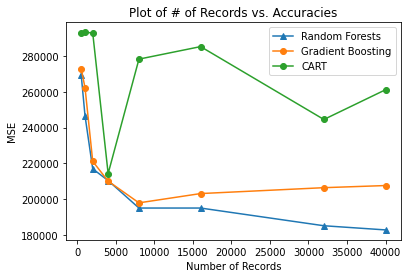

In [ ]:
x  = [res[0] for res in results_rf]
y1 = [res[1] for res in results_rf]
y2 = [res[1] for res in results_gb]
y3 = [res[1] for res in results_cm]
plt.plot(x, y1, label="Random Forests", marker='^')
plt.plot(x, y2, label="Gradient Boosting", marker='o')
plt.plot(x, y3, label="CART", marker='o')
plt.plot()

plt.xlabel("Number of Records")
plt.ylabel("MSE")
plt.title("Plot of # of Records vs. Accuracies")
plt.legend()
plt.show()

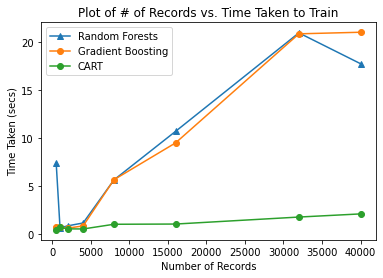

In [ ]:
x  = [res[0] for res in results_rf]
y1 = [res[2] for res in results_rf]
y2 = [res[2] for res in results_gb]
y3 = [res[2] for res in results_cm]
plt.plot(x, y1, label="Random Forests", marker='^')
plt.plot(x, y2, label="Gradient Boosting", marker='o')
plt.plot(x, y3, label="CART", marker='o')
plt.plot()

plt.xlabel("Number of Records")
plt.ylabel("Time Taken (secs)")
plt.title("Plot of # of Records vs. Time Taken to Train")
plt.legend()
plt.show()

In [ ]:
results_cm

[[500, 293103.09375, 0.4358103275299072],
 [1000, 293418.6875, 0.7031054496765137],
 [2000, 292985.5625, 0.545168399810791],
 [4000, 214235.828125, 0.5351271629333496],
 [8000, 278359.1875, 1.0245561599731445],
 [16000, 285371.5625, 1.047882080078125],
 [32000, 244542.875, 1.7769436836242676],
 [40000, 261204.671875, 2.1052486896514893]]

In [ ]:
results_gb

[[500, 272940.09375, 0.692237138748169],
 [1000, 262392.1875, 0.6943559646606445],
 [2000, 221099.34375, 0.6153028011322021],
 [4000, 210001.84375, 0.8535501956939697],
 [8000, 197832.953125, 5.670074224472046],
 [16000, 203034.90625, 9.5106041431427],
 [32000, 206332.90625, 20.878676414489746],
 [40000, 207526.9375, 21.04350471496582]]

In [ ]:
results_rf

[[500, 269679.34375, 7.44145941734314],
 [1000, 246594.375, 0.6500222682952881],
 [2000, 216878.375, 0.8603036403656006],
 [4000, 210317.171875, 1.1601903438568115],
 [8000, 194922.546875, 5.649001598358154],
 [16000, 194923.328125, 10.713460445404053],
 [32000, 185003.671875, 20.97702383995056],
 [40000, 182668.6875, 17.76360321044922]]